In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 115.5 MB/s eta 0:00:00


In [3]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 68.8 MB/s eta 0:00:00


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 127.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attentio

2.12.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
#from google.colab import files
#uploaded = files.upload()

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import shutil

## **Reading and preparing the dataset**

In [9]:
!gdown --id 15PCnk330VY6ymYf3mz4HEWBZSByH7sB5

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15PCnk330VY6ymYf3mz4HEWBZSByH7sB5
To: /content/labeled_data.csv
100% 4.02M/4.02M [00:00<00:00, 62.1MB/s]


In [10]:
df = pd.read_csv('labeled_data.csv')

In [11]:
nRowsRead = None # specify 'None' if want to read whole file
# labeled_data.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df0 = pd.read_csv('labeled_data.csv', delimiter=',', nrows = nRowsRead)
df0.dataframeName = 'labeled_data.csv'
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 34896 rows and 7 columns


In [12]:
df0.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0.0,3.0,0.0,0.0,3.0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1.0,3.0,0.0,3.0,0.0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2.0,3.0,0.0,3.0,0.0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3.0,3.0,0.0,2.0,1.0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4.0,6.0,0.0,6.0,0.0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [13]:
#Doing some adjustments

c=df0['class']
df0.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1
...,...,...,...
34891,"“Blacks are inherently inferior, lecherous, pr...",hate_speech,0
34892,"“Jews are conspiratorial, devious, treacherous...",hate_speech,0
34893,Distribution by a political party of leaflets ...,hate_speech,0
34894,A poster of a woman in a burka with text that ...,hate_speech,0


In [14]:
# Grouping data by label
df.groupby('label').count()

,text,category
label,,
0,6902,6902
1,23831,23831
2,4163,4163


In [15]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 34896
    hate: 6902 (19.78% of total)

Examples:
    Total: 34896
    Ofensive: 23831 (68.29% of total)

Examples:
    Total: 34896
    Neither: 4163 (11.93% of total)



## **Splitting the data between train, validation and test sets:**

In [16]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

In [18]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [19]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test         690
                         train       5591
                         val          621
neither            2     test         416
                         train       3372
                         val          375
offensive_language 1     test        2384
                         train      19302
                         val         2145

In [20]:
df

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,val
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,val
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
...,...,...,...,...
34891,"“Blacks are inherently inferior, lecherous, pr...",hate_speech,0,train
34892,"“Jews are conspiratorial, devious, treacherous...",hate_speech,0,train
34893,Distribution by a political party of leaflets ...,hate_speech,0,train
34894,A poster of a woman in a burka with text that ...,hate_speech,0,train


In [21]:
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

,text,category,label,data_type
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",offensive_language,1,train
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",offensive_language,1,train


In [22]:
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,val
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,val
14,""" bitch get up off me """,offensive_language,1,val
39,""" like Snoop said in 94 we dont love these hoes """,offensive_language,1,val
51,""" yall niggas b cuffing hoes cause yall aint n...",offensive_language,1,val


In [23]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,text,category,label,data_type
19,""" black bottle &amp; a bad bitch """,offensive_language,1,test
22,""" cant you see these hoes wont change """,offensive_language,1,test
29,""" i spend my money how i want bitch its my bus...",offensive_language,1,test
50,""" we dont trust these niggas all these bitches """,offensive_language,1,test
57,"""&amp; he's gone always be a hoe""",offensive_language,1,test


In [24]:
df.dtypes

text         object
category     object
label         int64
data_type    object
dtype: object

## **Build TensorFlow input**
[Reference](https://www.tensorflow.org/guide/data)

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

In [26]:
train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

While tf.data tries to propagate shape information, the default settings of Dataset.batch result in an unknown batch size because the last batch may not be full. Note the Nones in the shape:

batched_dataset
```
<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>
```
Use the drop_remainder argument to ignore that last batch, and get full shape propagation:

In [27]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# **Printing some Tweets**

In [30]:
for feat, targ in train_ds.take(1):
    print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b"U wanna piss a hoe off when u in the club &amp; she in front U Tryna dance for u do what I'm doing right now Tweet"
 b'When you told ya Homie she was a hoe but he still wifed it &#8220;@Lurk_God: Caption this http://t.co/rgbqEsSSHA&#8221;'
 b'We have already accepted many of these refugees with more to come.  Come on America (government) wake up! '
 b'RT @JohnnyFootbalI: Yeah @TigerWoods quit being a bitch about your back. Pop a few Viagra and get your horny ass back to dominating holes o&#8230;'
 b'Christians refugees from Iraq and Syria are not welcome in Britain.   '
 b'ion care who my niggas date b if the bitch make you happy and you cool with her then do you'
 b"He may be the President but that doesn't necessarily mean he's in the sole position of power in regard to making such decisions."
 b'@user This is a bandaid! Americans want total immigration reform and to build the wall! Get going Congress and do the right thing! #BuildThatWall #ImmigrationReform '
 b'Knockin 

# **Loading models from TensorFlow Hub**

In [31]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


I've chosen "bert_en_uncased_L-12_H-768_A-12"

This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at tensorflow/models/official/nlp/bert. It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

## **The preprocessing model**

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models, which implements this transformation using TF ops from the TF.text library. Hence, It is not necessary to run pure Python code outside the TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which can be read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

In [32]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [33]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Tweet: b'#Burundi Burundian refugees should go home! '
Label : 0
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1001 28836 28836  2319  8711  2323  2175  2188   999   102     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [34]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [35]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.39454615  0.99449885 -0.35915193  0.2793306   0.711556   -0.49637783
  0.9933674  -0.99635375 -0.13176288 -0.99600595  0.06725624 -0.81996006]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.59651434 -0.6579773  -0.35362545 ... -0.90114313  0.6852826
   0.4708554 ]
 [ 0.34172806 -0.10190173 -1.3965591  ... -0.9007485  -0.4059068
  -0.05035485]
 [-0.4829514  -0.9850728  -0.50328624 ... -0.81666005 -1.2107716
   1.0477202 ]
 ...
 [ 0.43568158  1.2027874  -0.1612744  ... -0.43903783  2.2675955
   0.08747809]
 [ 0.18993488 -0.8975848  -0.4544737  ... -1.1470177   0.3752224
   0.6454684 ]
 [ 0.4787173  -0.23553193  0.19673605 ... -0.17325336  0.9439968
   0.16264972]]


In [36]:
text_test = ['this is such an amazing movie!']

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_test)
# print(encoder_inputs)

encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
# print(outputs)

sequence_output = outputs["sequence_output"]
print(sequence_output)

tf.Tensor(
[[[-0.2894635   0.34321314  0.33231482 ...  0.21300751  0.7102076
   -0.0577114 ]
  [-0.2874215   0.31981048 -0.23018587 ...  0.5845506  -0.21329802
    0.72692144]
  [-0.6615703   0.68876755 -0.87433    ...  0.10877246 -0.26173204
    0.47855428]
  ...
  [ 0.07634915 -0.14029242 -0.23991841 ...  0.43109888  0.9132693
    0.21486607]
  [-0.44950545 -0.41251948 -0.18450806 ...  0.42683238  0.57654613
    0.5835243 ]
  [-1.0125371  -0.86389136  0.05829329 ...  0.3331204   0.3652097
    0.9429185 ]]], shape=(1, 128, 512), dtype=float32)


# **Techniques to deal with unbalanced data**

## **Calculate class weights**

One of the goals is to identify hate speech, but we don't have very many of those samples to work with, so I would want to have the classifier heavily weight the few examples that are available. I am going to do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [37]:
weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / ofensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.69
Weight for class 1: 0.49
Weight for class 2: 2.79


## **Set the correct initial bias**

These initial guesses (for the bias) are not great. The dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about log(1/n_classes): math.log(3) = 1,098612

In [38]:
#initial_output_bias = np.array([3.938462, 6.535164, 5.])
initial_output_bias = np.array([3.938462, 15, 5.])
initial_output_bias

array([ 3.938462, 15.      ,  5.      ])

# **BERT + CNN + LSTM**

In [39]:
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    # net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]

    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    net = tf.keras.layers.LSTM(64, return_sequences=True)(net)
    # net = tf.keras.layers.MaxPooling1D(2)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)

    net = tf.keras.layers.Conv1D(128, (2), activation='relu')(net)
    net = tf.keras.layers.LSTM(256, return_sequences=True)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)

    # net = tf.keras.layers.MaxPooling1D(2)(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)
    
    # net = tf.keras.layers.Flatten()(net)
    
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [40]:
classifier_model = build_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5834326 0.5833995 0.5808771]], shape=(1, 3), dtype=float32)


In [41]:
print(bert_raw_result)

tf.Tensor([[0.33688065 0.3367442  0.32637513]], shape=(1, 3), dtype=float32)


In [42]:
text_test

['this is such an amazing movie!']

In [43]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

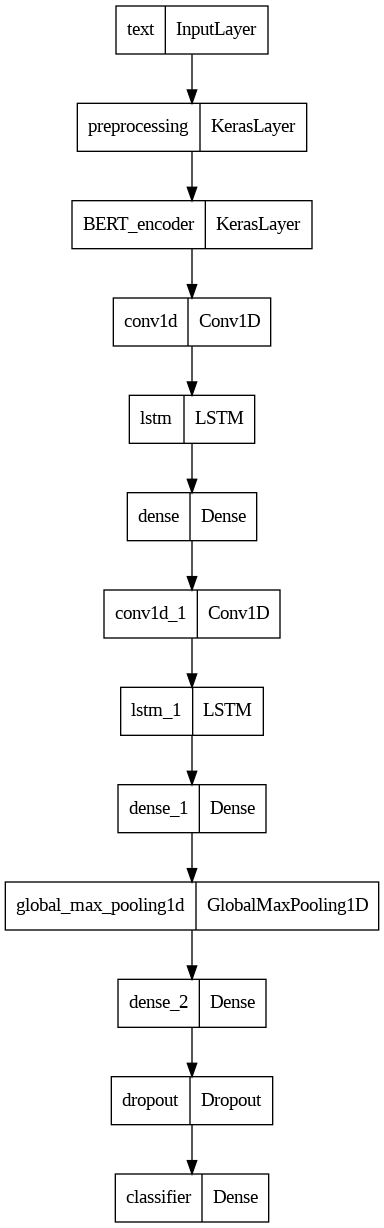

In [44]:
tf.keras.utils.plot_model(classifier_model)

In [45]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#metrics = tf.metrics.CategoricalCrossentropy()
#metrics = tf.metrics.Accuracy()

In [46]:
epochs = 80
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
model_history = classifier_model.fit(x=train_ds,
                                       validation_data=val_ds,
                                       epochs=epochs,
                                       class_weight=class_weight
                                      )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 70/884 [=>............................] - ETA: 1:36:35 - loss: 1.0700 - accuracy: 0.4656

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['acc', f1_m, precision_m, recall_m])

In [ ]:
loss, accuracy, f1_m, precision_m, recall_m = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1_m}')
print(f'Precision: {precision_m}')
print(f'Recall: {recall_m}')

In [ ]:
history_dict = model_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## **Export for inference**

Now you just save your fine-tuned model for later use.

In [ ]:
dataset_name = 'cnn_lstm_hate_speech'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
!zip -r /content/cnn_lstm_hate_speech_bert.zip cnn_lstm_hate_speech_bert

  adding: cnn_lstm_hate_speech_bert/ (stored 0%)
  adding: cnn_lstm_hate_speech_bert/saved_model.pb (deflated 91%)
  adding: cnn_lstm_hate_speech_bert/variables/ (stored 0%)
  adding: cnn_lstm_hate_speech_bert/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: cnn_lstm_hate_speech_bert/variables/variables.index (deflated 74%)
  adding: cnn_lstm_hate_speech_bert/keras_metadata.pb (deflated 92%)
  adding: cnn_lstm_hate_speech_bert/assets/ (stored 0%)
  adding: cnn_lstm_hate_speech_bert/assets/vocab.txt (deflated 53%)
  adding: cnn_lstm_hate_speech_bert/fingerprint.pb (stored 0%)


In [ ]:
shutil.copy('/content/cnn_lstm_hate_speech_bert.zip', '/content/drive/MyDrive/model_result')

'/content/drive/MyDrive/model_result/cnn_lstm_hate_speech_bert.zip'

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

# **Results for CNN + LSTM**

In [ ]:
result =  classifier_model.predict(test_ds)
print(result.shape)

110/110 [==============================] - 15s 127ms/step
(3490, 3)


In [ ]:
result[0:2]

array([[0.00000013, 0.9999999 , 0.00000006],
       [0.00000011, 0.9999764 , 0.00002344]], dtype=float32)

In [ ]:
classes = np.argmax(result, axis=-1)

## **Doing predictions and saving to np.array**

In [ ]:
tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(classifier_model.predict(tweet))

1/1 [==============================] - 2s 2s/step


In [ ]:
test_labels[0:2]

[array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 2,
        1, 1, 2, 1, 0, 1, 1, 1, 1, 1]),
 array([1, 2, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 2, 1])]

In [ ]:
predictions[0:2]

[array([[0.00002152, 0.9998185 , 0.00016001],
        [0.00000014, 0.99999976, 0.00000009],
        [0.00000012, 0.99999976, 0.00000007],
        [0.        , 0.00000015, 0.9999999 ],
        [0.00000452, 0.99999523, 0.00000025],
        [0.00000013, 0.9999999 , 0.00000006],
        [0.00000011, 0.9999999 , 0.00000005],
        [0.00000013, 0.99999976, 0.00000008],
        [0.00000286, 0.999997  , 0.00000012],
        [0.00000015, 0.9999999 , 0.00000005],
        [0.00000012, 0.99999976, 0.00000007],
        [0.00000076, 0.9999993 , 0.00000005],
        [0.00000154, 0.99998605, 0.00001242],
        [0.00000015, 0.99999976, 0.00000007],
        [0.9999999 , 0.0000001 , 0.        ],
        [0.00000017, 0.9999999 , 0.00000005],
        [0.00000025, 0.99999964, 0.00000007],
        [0.00000011, 0.9999999 , 0.00000006],
        [0.9999999 , 0.0000001 , 0.        ],
        [0.0000001 , 0.99999976, 0.00000011],
        [0.9999999 , 0.00000009, 0.        ],
        [0.00000001, 0.00000026, 0

In [ ]:
from itertools import chain

flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)

In [ ]:
type(y_pred)

numpy.ndarray

In [ ]:
y_test = np.array(list(chain.from_iterable(test_labels)))

In [ ]:
type(y_test)

numpy.ndarray

# **Confusion Matrix CNN + LSTM**

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 534  145   11]
 [  87 2264   33]
 [   5   49  362]]


In [ ]:
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

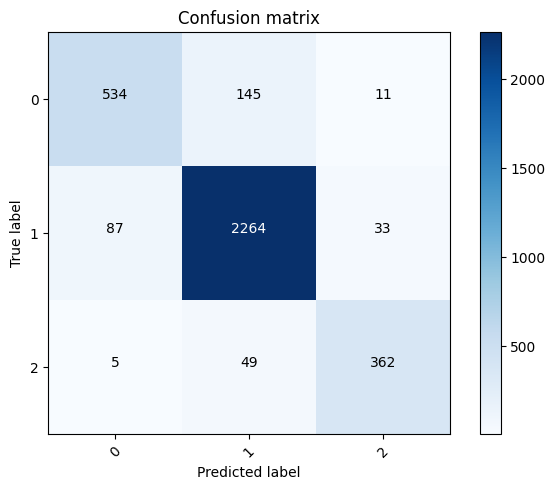

In [ ]:
plot_confusion_matrix(cm, classes = range(3))

# **Testing**

In [ ]:
sample_tweet = ['replace me with any comment you like']
sample_tweet = tf.convert_to_tensor(sample_tweet)
print(sample_tweet)
sample_tweet = sample_tweet.numpy()

tf.Tensor([b'replace me with any comment you like'], shape=(1,), dtype=string)


In [ ]:
# saved_model_path = 'cnn_lstm_hate_speech_bert'

# reloaded_model = tf.saved_model.load(saved_model_path)
# !unzip cnn_lstm_hate_speech_bert.zip -d /content

# result = reloaded_model(sample_tweet)
result = classifier_model.predict(sample_tweet)

1/1 [==============================] - 0s 35ms/step


In [ ]:
result

array([[0.000003  , 0.00004207, 0.99995494]], dtype=float32)

In [ ]:
type(print(result[0]))

[0.000003   0.00004207 0.99995494]


NoneType

In [ ]:
maximum = max(result[0])

In [ ]:
ans = np.where(result[0] == maximum)

In [ ]:
ans

(array([2]),)

In [ ]:
type(ans[0])

numpy.ndarray

In [ ]:
ans[0]

array([2])

In [ ]:
category = {0: 'hate speech', 1: 'offensive', 2: 'neutral'}

if not sample_tweet[0]:
    print('please enter an input')
else:
    print(category[ans[0][0]])

neutral
